In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [2]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                            test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, 
                                                            stratify=y_train_all, test_size=0.2, random_state=42)

In [3]:
print(x_train_all.shape)
print(x_train.shape)
print(x_val.shape)

(455, 30)
(364, 30)
(91, 30)


In [4]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.dot(x, self.w) + self.b    # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m   # 가중치에 대한 평균 그래디언트를 계산합니다
        b_grad = np.sum(err) / m        # 절편에 대한 평균 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1 , 1)
        y_val = y_val.reshape(-1, 1)
        m = len(x)
        self.w = np.ones((x.shape[1], 1))               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())       # 가중치를 기록합니다.
        np.random.seed(42)                         # 랜덤 시드를 지정합니다.

        for i in range(epochs):                    # epochs만큼 반복합니다.
            z = self.forpass(x)             # 정방향 계산
            a = self.activation(z)             # 활성화 함수 적용
            err = -(y - a)                  # 오차 계산
            w_grad, b_grad = self.backprop(x, err) 

            w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
            self.w -= self.lr * w_grad         # 가중치 업데이트
            self.b -= self.lr * b_grad         # 절편 업데이트
            # 가중치를 기록합니다.
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a)+(1-y)*np.log(1-a)))
        # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y) + self.reg_loss()/m)
            # 검증 세트에 대한 손실을 계산합니다
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = self.forpass(x)     # 정방향 계산
        return z > 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1,1))
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)     # 정방향 계산
        a = self.activation(z)         # 활성화 함수 적용
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val*np.log(a)+(1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss())/ len(y_val) )

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)


In [6]:
single_layer = SingleLayer(l2 = 0.01)
single_layer.fit(x_train_scaled, y_train,
                 x_val=x_val_scaled,y_val=y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)


np.float64(0.989010989010989)

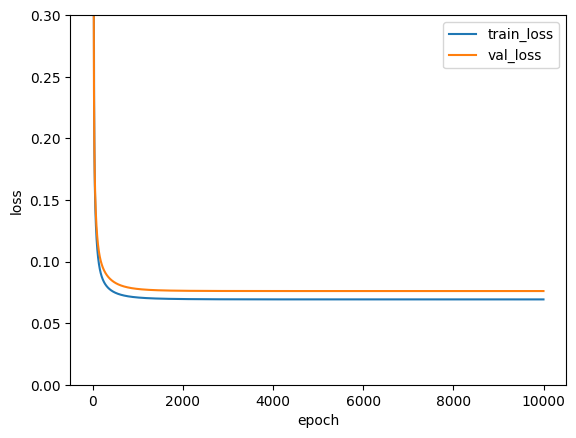

In [8]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

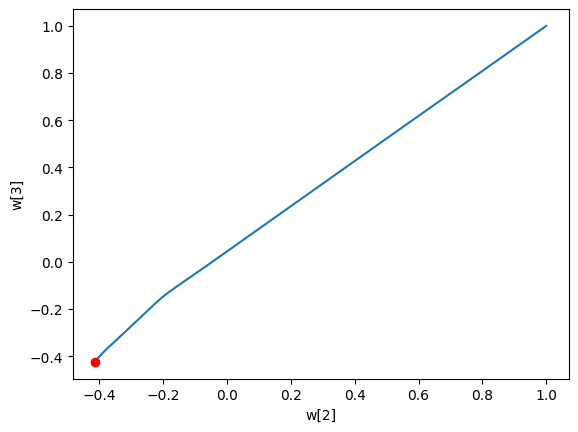

In [7]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()